In [1]:
import io
import os
import time
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

In [95]:
pairs = ['AUDJPY', 'AUDNZD', 'AUDUSD', 'CADJPY', 'CHFJPY', 'EURGBP', 'EURJPY', 'EURUSD', 'GBPJPY', 'GBPUSD', 'NZDUSD', 'USDCAD']
years = ['2012', '2013', '2014', '2015', '2016', '2017']
months = ['JANUARY', 'FEBRUARY', 'MARCH', 'APRIL', 'MAY', 'JUNE', 'JULY', 'AUGUST', 'SEPTEMBER', 'OCTOBER', 'NOVEMBER', 'DECEMBER']

def get_pickle(pairs=None, years=None, months=None, directory='data'):
    def cast_to_array(param):
        if type(param) in [str, type(None)]: 
            param = [param]
        return param
    
    def filter_files(params, files = []):
        _files = []
        data_files = [f for f in os.listdir('data') if '.pickle' in f]
        for param in cast_to_array(params):
            if not param:
                break
            if len(param) == 2:
                sym = '.'
            else:
                sym = '-'
            _files = [f for f in data_files if param + sym in f]
            files += _files
        return files
    
    files = []
    files = filter_files(pairs, files)
    files = filter_files(years, files)
    files = filter_files(months, files)

    if directory[-1] != '/':
        directory += '/'
        
    df = None
    for f in files:
        _df = pd.read_pickle(directory + f)
        if type(df) != pd.DataFrame:
            df = _df
        else:
            df = pd.concat([df, _df])
            
    df = df[df.volume > 0]
    #df['next_open'] = df.open.shift(-1)
            
    return df.sort_index()

def quick_plot(df):
    num_of_pairs = len(df.pair.unique())
    
    cols = int(num_of_pairs/(3-1))
    if num_of_pairs == 1:
        rows = cols = 1
    elif num_of_pairs < 3:
        rows = num_of_pairs
    else:
        rows = 3
    
    fig=plt.figure(figsize=(9*rows, 6*cols), dpi= 80, facecolor='w', edgecolor='k')
    
    for v, pair in enumerate(df.pair.unique()):
        df_pair = df[df.pair == pair]
        ax = plt.subplot(cols, rows, v + 1)
        ax.text(0.5, 0.9, pair, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        ax.plot(df_pair.index, df_pair.close)

    plt.show()

In [99]:
df = get_pickle('2012')
df = df[df.pair == "EUR/USD"]
df['next_open'] = df.open.shift(-1)
dff = df.copy()

# Time Feature

In [32]:
def sin_encode(t, T):
    return np.sin(2*np.pi*(t/T))

def encode_temporal(index, name):
    _index = index
    if name == "day_of_week":
        index = index.dayofweek
    if name == "hour":
        index = index.hour
    if name == "minute":
        index = index.minute
        
    T = len(index.unique())
    return pd.Series(sin_encode(index, T), index=_index, name=name)

def quick_plot_encoding(encoding, xlim=1000):
    plt.plot(encoding)
    plt.xlim(encoding.index[0],encoding.index[xlim])
    plt.show()

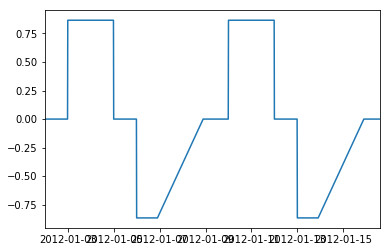

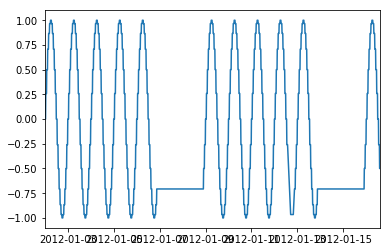

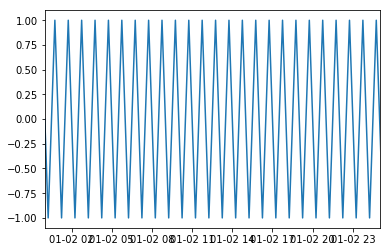

In [33]:
day_of_week_encode = encode_temporal(dff.index, name='day_of_week')
hour_encode = encode_temporal(dff.index, name='hour')
minute_encode = encode_temporal(dff.index, name='minute')

quick_plot_encoding(day_of_week_encode)
quick_plot_encoding(hour_encode, 1000)
quick_plot_encoding(minute_encode, 100)

# Market Feature

In [34]:
from scipy.stats import zscore

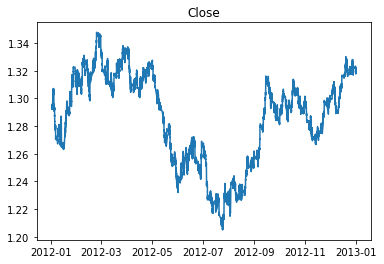

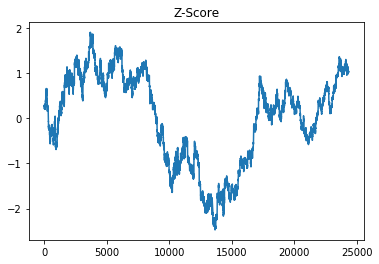

In [35]:
plt.plot(dff.close)
plt.title('Close')
plt.show()

zs = zscore(dff.close)
plt.plot(zs)
plt.title('Z-Score')
plt.show()

In [36]:
def log_return(series):
    return np.log(series) - np.log(series.shift(1))

def rolling_zscore(arr):
    return zscore(arr)[-1]

def rolling_zscore_alt(log_ret):
    return (log_ret - log_ret.rolling(96).mean()) / log_ret.rolling(96).std()

def gen_log_return(series, zscore_roll=96, lookback=8, clip=(-10,10)):
    log_ret = log_return(series)
    norms = log_ret.rolling(zscore_roll).apply(rolling_zscore)
    norms = norms.clip(*clip)

    log_returns = {}
    for s in range(lookback):
        log_returns['{}_log_returns_{}'.format(series.name, s)] = norms.shift(s)

    return pd.DataFrame(log_returns)

#close_lr = gen_log_return(dff.close)
#volume_lr = gen_log_return(dff.volume)

# Position Encoding

In [37]:
def gen_pos_encoding(df):
    return pd.DataFrame(np.zeros(shape=(df.close.size, 3)),
                      columns=['pos_short', 'pos_neutral', 'pos_long'],
                      index=dff.index)

# Collecting Calculated Variable

In [38]:
def calculate_meta_variables(dff):
    # Time Encoding
    dff = dff.join(encode_temporal(dff.index, name='day_of_week'))
    dff = dff.join(encode_temporal(dff.index, name='hour'))
    dff = dff.join(encode_temporal(dff.index, name='minute'))
    
    # Position Encoding
    dff = dff.join(gen_pos_encoding(dff))
    
    return dff
    

def calculate_market_variables(dff):
    # Market Feature
    dff = dff.join(gen_log_return(dff.close))
    dff = dff.join(gen_log_return(dff.volume))

    # Cleaning
    dff = dff.drop(columns=["high", "low"])
    
    return dff

# Reward

In [101]:
df = calculate_market_variables(dff)
df = calculate_meta_variables(df)

In [102]:
df['portfolio'] = 0

In [103]:
df

,pair,open,close,volume,next_open,close_log_returns_0,close_log_returns_1,close_log_returns_2,close_log_returns_3,close_log_returns_4,...,volume_log_returns_5,volume_log_returns_6,volume_log_returns_7,day_of_week,hour,minute,pos_short,pos_neutral,pos_long,portfolio
datetime,,,,,,,,,,,,,,,,,,,,,
2012-01-02 00:00:00,EUR/USD,1.294840,1.294550,119,1.294570,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0
2012-01-02 00:15:00,EUR/USD,1.294570,1.294720,110,1.294705,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.000000,-1.000000e+00,0.0,0.0,0.0,0
2012-01-02 00:30:00,EUR/USD,1.294705,1.294830,37,1.294835,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.000000,5.389684e-15,0.0,0.0,0.0,0
2012-01-02 00:45:00,EUR/USD,1.294835,1.294370,337,1.294500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.000000,1.000000e+00,0.0,0.0,0.0,0
2012-01-02 01:00:00,EUR/USD,1.294500,1.294315,267,1.294310,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.258819,0.000000e+00,0.0,0.0,0.0,0
2012-01-02 01:15:00,EUR/USD,1.294310,1.294270,209,1.294305,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.258819,-1.000000e+00,0.0,0.0,0.0,0
2012-01-02 01:30:00,EUR/USD,1.294305,1.294420,223,1.294420,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.258819,5.389684e-15,0.0,0.0,0.0,0
2012-01-02 01:45:00,EUR/USD,1.294420,1.293975,210,1.294005,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.258819,1.000000e+00,0.0,0.0,0.0,0
2012-01-02 02:00:00,EUR/USD,1.294005,1.293675,175,1.293660,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.500000,0.000000e+00,0.0,0.0,0.0,0


In [104]:
def calc_action(action):
    if action == 'pos_neutral':
        return 0
    if action == 'pos_short':
        return -1
    if action == 'pos_long':
        return 1

def calc_portfolio(df, index, trade_size = 100, spread=0.0001):
    if type(index) == pd._libs.tslib.Timestamp:
        index = df.index.get_loc(index)
        
    pf_col = df.columns.get_loc('portfolio')
    long_col = df.columns.get_loc('pos_long')
    short_col = df.columns.get_loc('pos_short')
    close_col = df.columns.get_loc('next_open')
    open_col = df.columns.get_loc('open')
        
    v_0 = df.iat[index - 1, pf_col]
    
    a_0 = 0
    if df.iat[index-1, long_col]:
        a_0 = 1
    elif df.iat[index-1, short_col]:
        a_0 = -1

    a = 0
    if df.iat[index, long_col]:
        a = 1
    elif df.iat[index, short_col]:
        a = -1
     
    c = df.iat[index, close_col]
    o = df.iat[index, open_col]
    d = trade_size * abs(a - a_0) * spread
    
    return v_0 + a * trade_size * (c - o) - d

def calc_reward(df, index):
    pf_index = df.columns.get_loc('portfolio')
    return np.log(df.iat[index, pf_index] / df.iat[index-1, pf_index])

In [141]:
def run_backtest(df):
    actions = {-1: 'pos_short', 0: 'pos_neutral', 1: 'pos_long'}
    close_col = df.columns.get_loc('close')
    open_col = df.columns.get_loc('open')
    next_col = df.columns.get_loc('next_open')

    # init portfolio
    df.portfolio = 0.0
    df.at[df.index[0], 'portfolio'] = 0.0#100000
    df.pos_short = 0
    df.pos_neutral = 0
    df.pos_long = 0

    for n, (dt, row) in enumerate(df.iterrows()):
        if n <= 0:
            continue
            
        index = df.index.get_loc(dt)
            
        # Compare MA
        #decision = (df.iloc[n-10:n, close_col] - df.iloc[n-10:n, open_col]).mean() 
        #decision -= (df.iloc[n-30:n, close_col] - df.iloc[n-30:n, open_col]).mean()
        #action = int(decision < 0)
        
        # Random Choice
        action = np.random.choice([0, 1])
        
        # Peak Ahead (debugging)
        #try:
        #    action = int(df.iat[index + 1, next_col] > df.iat[index, open_col])
        #except:
        #    action = 0
        
        # Buy and Hold (should match price)
        #action = 1
        
        df.at[dt, actions[action]] = action

        p = calc_portfolio(df, dt)
        df.at[dt, 'portfolio'] = p
        if not n % 1000:
            print(n, "/", len(df))
            print(df.at[dt, 'portfolio'])
            print()
    
    return df

1000 / 24334
-5.507500000000019

2000 / 24334
-10.860000000000307

3000 / 24334
-15.30900000000025

4000 / 24334
-16.45800000000035

5000 / 24334
-23.3975000000015

6000 / 24334
-26.211500000002175

7000 / 24334
-34.31300000000262

8000 / 24334
-38.571000000001405

9000 / 24334
-45.19000000000057

10000 / 24334
-51.161999999999615

11000 / 24334
-58.937499999998764

12000 / 24334
-62.535999999997536

13000 / 24334
-67.72849999999909

14000 / 24334
-74.6660000000011

15000 / 24334
-79.50700000000376

16000 / 24334
-83.48000000000638

17000 / 24334
-86.85700000000904

18000 / 24334
-91.18000000001197

19000 / 24334
-96.246000000014

20000 / 24334
-100.5455000000161

21000 / 24334
-106.15450000001871

22000 / 24334
-108.74750000002142

23000 / 24334
-114.27300000002417

24000 / 24334
-118.86000000002697



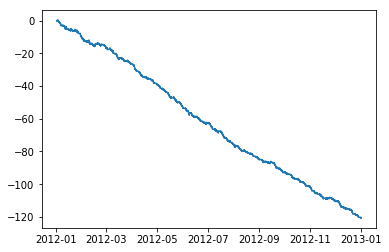

In [142]:
results = run_backtest(df)
plt.plot(results.portfolio)
plt.show()